In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.constants import h, c, k
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

file = 'arcturus.txt'

wl = []
spectrum = []
# The wl of the spectrum is in the first row.
# The flux is in the second row. 
# We will read the file line by line and split each line into two values.
with open(file, 'r') as file:
    for line in file:
        # Process data lines (wavelength and flux values)
        v = line.split()
        if len(v) == 2:  # Ensure there are exactly two values
            wl_value = float(v[0])
            flux_value = float(v[1])
            # Filter by max wavelength
            if wl_value <= 15000:
                wl.append(wl_value)
                spectrum.append(flux_value)
# Convert lists to numpy arrays for easy manipulation
wl = np.array(wl)
spectrum = np.array(spectrum)


In [2]:
# Convert flux to log space for fitting
log_flux = np.log(spectrum)

method = 'running_average'

# Define Planck function in log-flux space
def planck_log(w, T, a):
    w_m = w * 1e-10  # Convert wavelength to meters
    return np.log(a * (2.0 * h * c**2) / (w_m**5) / (np.exp((h * c) / (w_m * k * T)) - 1.0))

if method == 'blackbody':
    # NOT USED ANYMORE! DOESN'T WORK WELL
    # Fit in log-flux space    
    guess = [6000, 1e-8]  # Temperature and scaling factor
    popt, _ = curve_fit(planck_log, wl, log_flux, p0=guess)
    
    # Convert the result back to linear flux space
    log_continuum = planck_log(wl, *popt)
    continuum = np.exp(log_continuum)

elif method == 'running_average':
    # Initialize an empty continuum array
    continuum = np.zeros_like(spectrum)
    
    windowSize = 50
    threshold = 0.8

    for i in range(len(spectrum)):
        half_window = min(i, len(spectrum) - i - 1, windowSize // 2)
        
        # Define the window range in linear space
        window_start = i - half_window
        window_end = i + half_window + 1
        
        # Calculate the running average in log-flux space, excluding deep absorption lines
        window_flux = log_flux[window_start:window_end]
        filtered_flux = window_flux[window_flux > np.log(threshold * np.median(np.exp(window_flux)))]
        
        # Take the median of the filtered flux, or the median of the whole window if no filtering
        continuum[i] = np.exp(np.median(filtered_flux)) if len(filtered_flux) > 0 else np.exp(np.median(window_flux))



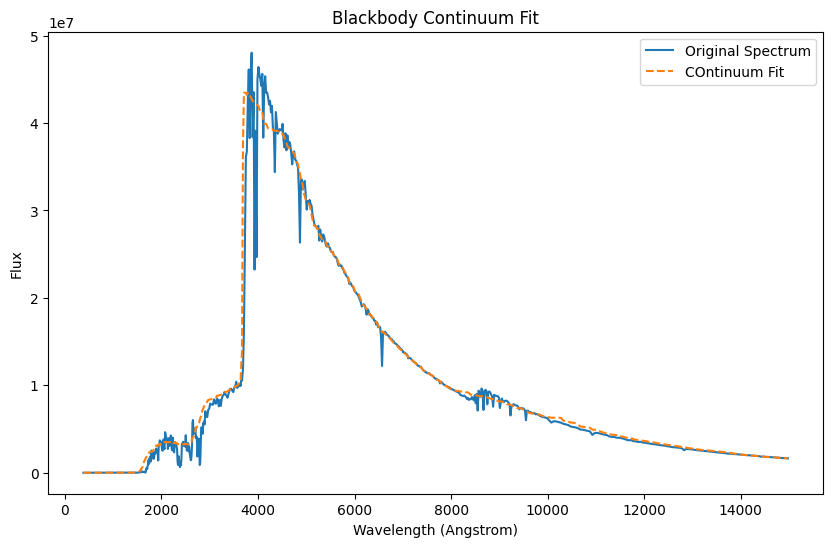

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(wl, spectrum, label="Original Spectrum")
plt.plot(wl, continuum, label=f"COntinuum Fit", linestyle="--")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.legend()
plt.title("Blackbody Continuum Fit")
plt.show()


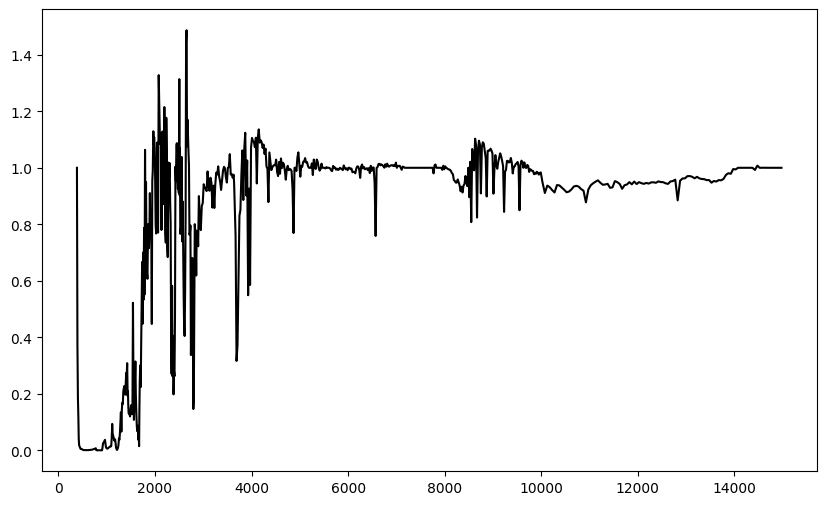

In [4]:
# Step 3: Normalize the spectrum by the continuum
spectrum = spectrum / continuum
plt.figure(figsize=(10, 6))
plt.plot(wl, spectrum, label="Normalized Spectrum", color="black")
plt.show()

The FWHM of Halpha is 17.18 Å
The FWHM of Hbeta is 17.29 Å


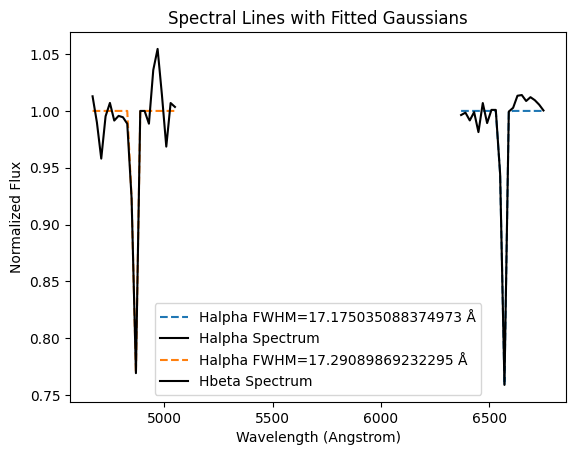

In [5]:
fwhm_results = []


# Start with Halpha
center_wavelength = 6563
# Fit Gaussian around each target line
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

# Create the inverted spectrum for fitting
inverted_spectrum = 1 - spectrum

# Initial guess based on the target line center
idx = (np.abs(wl - center_wavelength)).argmin()
amp_guess = inverted_spectrum[idx]
sigma_guess = 10  # Initial guess for sigma
guess = [amp_guess, center_wavelength, sigma_guess]

# Narrow region around the line center for fitting
mask_halpha = (wl > center_wavelength - 200) & (wl < center_wavelength + 200)

# Check if there are enough points to fit
if np.sum(mask_halpha) < 5:  # Require at least 5 points in the window
    print(f"Not enough data points to fit Halpha")
else:   
    popt, _ = curve_fit(gaussian, wl[mask_halpha], inverted_spectrum[mask_halpha], p0=guess)

    # Calculate FWHM from the fit sigma
    amp, mu, sigma = popt
    fwhm = 2 * np.sqrt(2 * np.log(2)) * np.abs(sigma)
    fwhm_results.append(('Halpha', mu, fwhm))


# Plot the fitted Gaussian, inverted back to negative values
plt.plot(wl[mask_halpha], 1-gaussian(wl[mask_halpha], *popt), linestyle='--', label='Halpha FWHM=%s Å' % fwhm)
plt.plot(wl[mask_halpha], spectrum[mask_halpha], label='Halpha Spectrum', color='black')
plt.title("Spectral Lines with Fitted Gaussians")


print('The FWHM of Halpha is %.2f Å' % fwhm)


# Now do Hbeta
center_wavelength = 4861
# Fit Gaussian around each target line
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

# Create the inverted spectrum for fitting
inverted_spectrum = 1 - spectrum

# Initial guess based on the target line center
idx = (np.abs(wl - center_wavelength)).argmin()
amp_guess = inverted_spectrum[idx]
sigma_guess = 10  # Initial guess for sigma
guess = [amp_guess, center_wavelength, sigma_guess]

# Narrow region around the line center for fitting
mask_hbeta = (wl > center_wavelength - 200) & (wl < center_wavelength + 200)

# Check if there are enough points to fit
if np.sum(mask_hbeta) < 5:  # Require at least 5 points in the window
    print(f"Not enough data points to fit Halpha")
else:   
    popt, _ = curve_fit(gaussian, wl[mask_hbeta], inverted_spectrum[mask_hbeta], p0=guess)

    # Calculate FWHM from the fit sigma
    amp, mu, sigma = popt
    fwhm = 2 * np.sqrt(2 * np.log(2)) * np.abs(sigma)
    fwhm_results.append(('Hbeta', mu, fwhm))


# Plot the fitted Gaussian, inverted back to negative values
plt.plot(wl[mask_hbeta], 1-gaussian(wl[mask_hbeta], *popt), linestyle='--', label='Halpha FWHM=%s Å' % fwhm)
plt.plot(wl[mask_hbeta], spectrum[mask_hbeta], label='Hbeta Spectrum', color='black')
plt.title("Spectral Lines with Fitted Gaussians")


print('The FWHM of Hbeta is %.2f Å' % fwhm)

plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Normalized Flux")

plt.legend()

plt.show()
